In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from astropy.stats import poisson_conf_interval
from astropy.time import Time

import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({
    'savefig.dpi': 300, 
    "figure.dpi": 300,
    "font.family": "Arial",
    "font.size": 6,
    "pdf.fonttype": 42,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    "xtick.major.size": 3,
    "ytick.major.size": 3,
    "lines.linewidth": 1.0,
})

cm = 1/2.54  # centimeters in inches

from vis_ds import DynamicSpectra, getFDF, findpeaks
from burst import BurstDS

In [2]:
### parameters
period_second = 2656.2412
pzero_second = 1960.

In [3]:
### functions for chandra plotting
def get_toas_phase(toas, period, pzero=0.):
    """
    Get the phase of the TOAs given a period and a reference time.
    
    Parameters
    ----------
    toas : array_like
        Array of TOAs in MJD.
    period : float
        Period in seconds.
    pzero : float, optional
        Reference time in MJD. Default is 0.

    Returns
    -------
    array_like
        Array of phases corresponding to the TOAs.
    """
    ti = toas - pzero + 50814.0 * 86400.
    v = 1.0 / period # frequency
    turns = v * ti
    return turns % 1

def fold_toas(toas, period, pzero=0., nbins=20, repeat=True):
    """
    Fold TOAs into bins and calculate the counts in each bin.

    Parameters
    ----------
    toas : array_like
        Array of TOAs in MJD.
    period : float
        Period in seconds.
    pzero : float, optional
        Reference time in MJD. Default is 0.
    nbins : int, optional
        Number of bins to use. Default is 20.
    repeat : bool, optional
        Whether to repeat the period. Default is True.

    Returns
    -------
    tuple
        Tuple containing:
        - bin_centers : array_like
            Array of bin centers.
        - bin_counts : array_like
            Array of counts in each bin.
        - bin_count_lolim : array_like
            Lower limit of counts in each bin.
        - bin_count_hilim : array_like
            Upper limit of counts in each bin.
    """
    phases = get_toas_phase(toas, period, pzero)
    bins = np.linspace(0, 1, nbins+1)
    bin_counts = np.zeros(nbins)
    bin_count_lolim = np.zeros(nbins)
    bin_count_hilim = np.zeros(nbins)
    for i in range(nbins):
        bin_count = ((phases >= bins[i]) & (phases < bins[i+1])).sum()
        bin_counts[i] = bin_count
        bin_lolim, bin_hilim = poisson_conf_interval(bin_count, interval='frequentist-confidence')
        bin_count_lolim[i] = bin_lolim
        bin_count_hilim[i] = bin_hilim
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    if repeat:
        bin_centers = np.concatenate([bin_centers, 1+bin_centers])
        bin_counts = np.concatenate([bin_counts, bin_counts])
        bin_count_lolim = np.concatenate([bin_count_lolim, bin_count_lolim])
        bin_count_hilim = np.concatenate([bin_count_hilim, bin_count_hilim])
    
    return bin_centers, bin_counts, bin_count_lolim, bin_count_hilim

def plot_chandra_fold(
    ax, toas, period, pzero=0., nbins=20, repeat=True, net_percent=0.9, 
):
    ### get bins, counts etc.
    bins, counts, count_lolims, count_hilims = fold_toas(toas, period, nbins=nbins, repeat=repeat, pzero=pzero)
    ### estimate background
    src_bkg = 1 - net_percent
    bkg_ = len(toas) * src_bkg / nbins
    bkg_lolim, bkg_hilim = poisson_conf_interval(bkg_, interval='frequentist-confidence')
    
    ### plot lightcurve
    ax.step(bins, counts, color="red", where="mid",)
    ax.errorbar(
        x=bins, y=counts, yerr=[counts-count_lolims, count_hilims-counts],
        marker='.', ls="", capsize=1.2, ecolor="red"
    )
    ### plot background
    bkg_phases = [0, 2] if repeat else [0, 1]
    ax.fill_between(bkg_phases, bkg_lolim, bkg_hilim, facecolor="green", alpha=0.5)
    
    ### set ylimit and plot normalised flux...
    count_ylimits = (0, (np.max(counts) + np.max(counts) ** 0.5) * 1.05)
    ax.set_ylim(*count_ylimits)
    
    ax_flux = ax.twinx()
    flux_ylimits = (0, count_ylimits[1]/np.mean(counts))
    ax_flux.set_ylim(*flux_ylimits)
    
    ### plot unit normalised flux
    ax_flux.plot(bkg_phases, [1., 1.], ls="--", color="green")
    
    ### set labels...
    ax.set_xlabel("Phase", )
    ax.set_ylabel("Counts/bin", )
    ax_flux.set_ylabel("Normalized Flux")
    
    return ax

def get_phasebin_time(epochs, epoche, period_second, pzero_second, phases=0.0, phasee=1.0):
    """
    get how many seconds are there in a given bin
    
    epochs, epoche: mjd in seconds, i.e., mjd * 86400
    period_second, pzero_second: period and pzero in seconds
    """
    turns = (epochs - pzero_second) / period_second
    turne = (epoche - pzero_second) / period_second
    
    turns = (epochs - pzero_second) / period_second
    turne = (epoche - pzero_second) / period_second

    turnsint = np.floor(turns)
    turns -= turnsint; turne -= turnsint
    turneint = np.ceil(turne)

    binphases = 0
    for t in range(int(turneint)):
        cycle_ts = turns % 1 if turns > t else 0
        cycle_te = turne % 1 if turne < t+1 else 1
        ### time to decide how many phases are there in each cycle...
        cyclebin_len = min(cycle_te, phasee) - max(cycle_ts, phases)
#         print(cyclebin_len)
        if cyclebin_len > 0: binphases += cyclebin_len
            
    return binphases * period_second

def get_bin_time(epoch_info, period_second, pzero_second, nbins=22):
    bins = np.linspace(0, 1, nbins+1)
    bintimes = np.zeros(nbins)
    
    for epoch_line in epoch_info:
        epochs, epoche, _, _ = epoch_line
        epochs += 50814.0 * 86400.
        epoche += 50814.0 * 86400.
        for i in range(nbins):
            bintime = get_phasebin_time(epochs, epoche, period_second, pzero_second, bins[i], bins[i+1])
            bintimes[i] += bintime
    return bintimes

def plot_bintime(ax_bin, epoch_info, period_second, pzero_second, nbins=20, repeat=True):
    bins = np.linspace(0, 1, nbins+1)
    bincenter = (bins[:-1] + bins[1:]) / 2
    bintimes = get_bin_time(epoch_info, period_second, pzero_second, nbins) / 1e3 # in the unit of ks
    print(bincenter.shape)
    
    if repeat:
        bins = np.concatenate([bins, 1+bins[1:]])
        bintimes = np.concatenate([bintimes, bintimes])
        
    ax_bin.stairs(bintimes, bins, color="red", fill=True, alpha=0.3)
    return ax_bin

In [4]:
### load radio data
longpkls = [
    ### askap pickles
    ("../data/askap_SB58609.beam13.J1832-0911.pkl", "ASKAP"),
    ("../data/askap_SB58753.beam13.J1832-0911.pkl", "ASKAP"),
    ("../data/askap_SB60091.beam13.J1832-0911.pkl", "ASKAP"),
    ("../data/askap_SB64280.beam27.J1832-0911.pkl", "ASKAP"),
    ("../data/askap_SB64328.beam13.J1832-0911.pkl", "ASKAP"),
    ("../data/askap_SB64345.beam19.J1832-0911.pkl", "ASKAP"),
    ### gmrt pickle
    ("../data/gmrt_16878.J1832-0911.B4.pkl", "GMRT"),
    ### vlite csv
    ("../data/vlite_240215.csv", "VLA"),
    ### meerkat uhf pickle
    ("../data/meerkat_1708396251.J1832-0911.npz", "MKT"),
]

starttimes = []
plot_phases = []
plot_lcs = []
labels = []

for pklf, telescope in longpkls:
    ds = BurstDS(pklf, period=period_second/86400, pzero=pzero_second/86400, telescope=telescope)
    
    ds.fold_lc(nbins=220, norm=False)
    starttimes.append(ds.time[0])
    plot_phases.append(ds.fphase)
    plot_lcs.append(ds.flc)
    labels.append("{} - {}".format(telescope, Time(ds.time[0], format="mjd").iso[:10]))
    
tidx_order = np.argsort(starttimes)

In [5]:
### load x-ray data
toas = np.loadtxt('../data/chandra_2402obs_J1832_photon_info.txt')[:,0]
epoch_info = np.loadtxt('../data/chandra_2402obs_J1832_epoch.txt')

(22,)


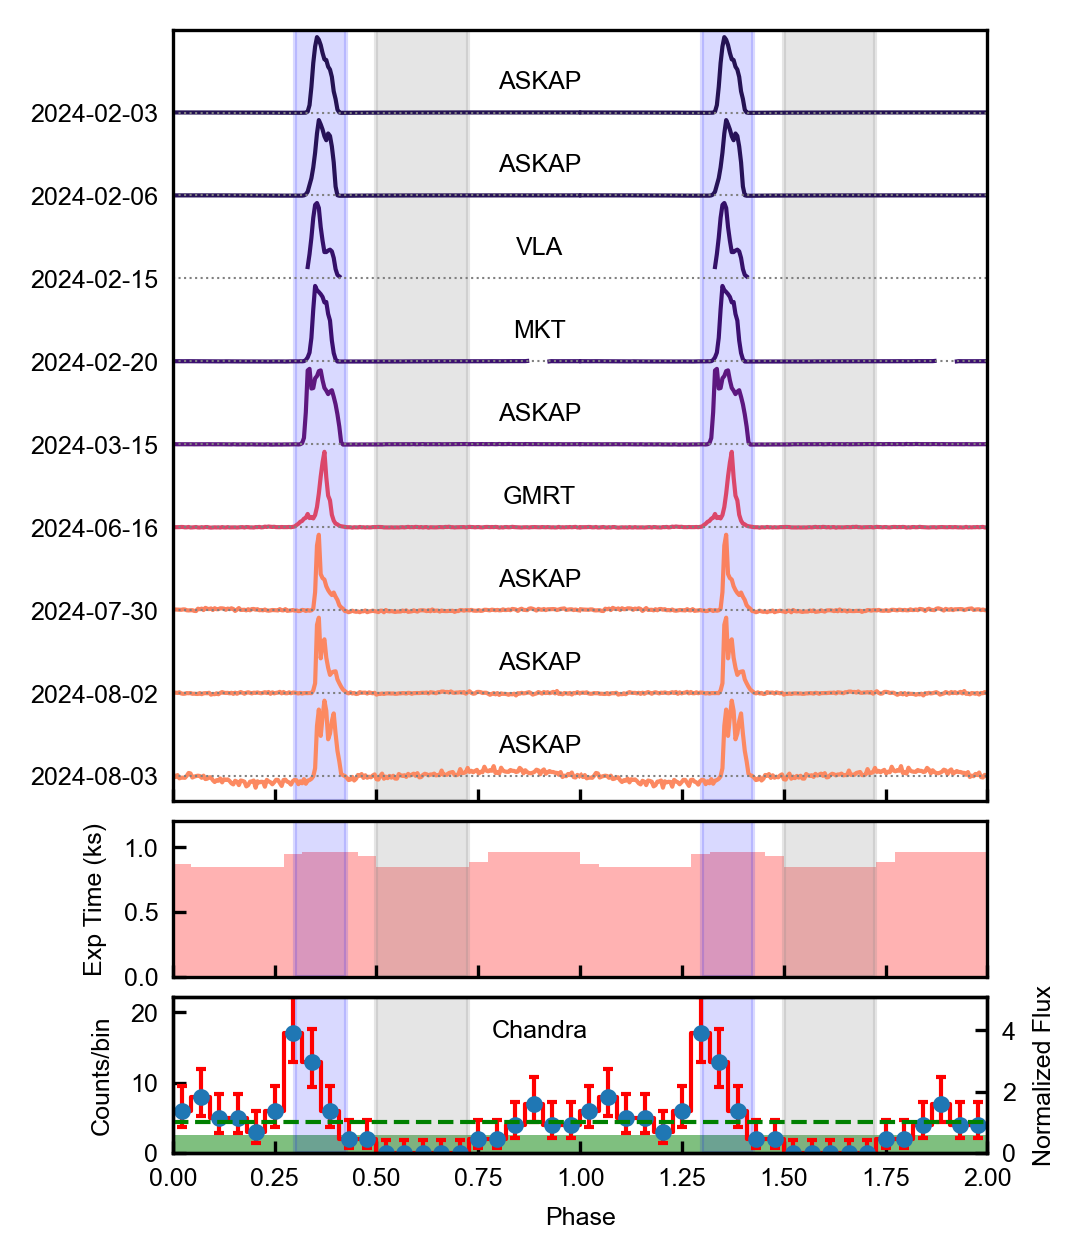

In [8]:
fig = plt.figure(figsize=(8.9*cm, 12.35*cm))
grid = GridSpec(nrows=len(tidx_order)+4, ncols=1, figure=fig, wspace=0.12, hspace=0.3)

### colormap setting
plotcmap = plt.get_cmap("magma")
cmax = 60600; cmin = 60300

fontsize = 6

yticklabels = []; yticks = []

ax_radio = fig.add_subplot(grid[:len(tidx_order), 0])
for i, tidx in enumerate(tidx_order):
    fphase = plot_phases[tidx]
    flc = plot_lcs[tidx]
    label = labels[tidx]
    labelsplit = label.split("-")
    telescope = labelsplit[0].strip()
    date = "-".join([i.strip() for i in labelsplit[1:]])
    startmjd = starttimes[tidx]
    
    lcolor = plotcmap((startmjd - cmin)/(cmax - cmin))
    
    ### normalised
    flc = flc / np.nanmax(flc) / 1.1
    
    ax_radio.plot(fphase, flc - i, color=lcolor,)
    ax_radio.plot(fphase + 1., flc - i, color=lcolor)
    
    ax_radio.text(0.9, -i+0.5, telescope, ha="center", va="top", fontsize=fontsize)
    
    yticklabels.append(date)
#     yticklabels.append(" ")
    yticks.append(-i)
    
ax_radio.set_yticks(yticks, yticklabels)
ax_radio.tick_params(axis="y", which="both", length=0.0)
for ybase in yticks: ax_radio.axhline(y=ybase, ls=":", lw=0.5, color="grey")
# ax_radio.set_xlabel("Phase")
ax_radio.tick_params(labelbottom=False)
ax_radio.set_xlim(-0.0, 2.0)

pphase = 0.3 #+ 0.38
wphase = 0.125

ax_radio.axvspan(xmin=pphase, xmax=pphase+wphase, color="blue", alpha=0.15)
ax_radio.axvspan(xmin=1+pphase, xmax=1+pphase+wphase, color="blue", alpha=0.15)
ax_radio.set_ylim(-i-0.3, 1)

ax_xray = fig.add_subplot(grid[len(tidx_order)+2:, 0], sharex=ax_radio)
ax_xray = plot_chandra_fold(ax_xray, toas, period_second, pzero_second, nbins=22, repeat=True)

# ax_xray.text(1., 19., "Chandra\n2024-02-14", ha="center", va="top", fontsize=11)
ax_xray.text(0.9, 19., "Chandra", ha="center", va="top", fontsize=fontsize)


ax_xray.axvspan(xmin=pphase, xmax=pphase+wphase, color="blue", alpha=0.15)
ax_xray.axvspan(xmin=1+pphase, xmax=1+pphase+wphase, color="blue", alpha=0.15)

ax_xtime = fig.add_subplot(grid[len(tidx_order):len(tidx_order)+2, 0], sharex=ax_radio)
ax_xtime = plot_bintime(ax_xtime, epoch_info, period_second, pzero_second, nbins=22, repeat=True)
ax_xtime.tick_params(labelbottom=False)
ax_xtime.set_ylabel("Exp Time (ks)")
ax_xtime.set_ylim(0., 1.2)

### radio pulse
ax_xtime.axvspan(xmin=pphase, xmax=pphase+wphase, color="blue", alpha=0.15)
ax_xtime.axvspan(xmin=1+pphase, xmax=1+pphase+wphase, color="blue", alpha=0.15)

### plot potential eclipsing part

ephase = 0.5
ewphase = 0.225

ax_xray.axvspan(xmin=ephase, xmax=ephase+ewphase, color="gray", alpha=0.2)
ax_xray.axvspan(xmin=1+ephase, xmax=1+ephase+ewphase, color="gray", alpha=0.2)
ax_radio.axvspan(xmin=ephase, xmax=ephase+ewphase, color="gray", alpha=0.2)
ax_radio.axvspan(xmin=1+ephase, xmax=1+ephase+ewphase, color="gray", alpha=0.2)
ax_xtime.axvspan(xmin=ephase, xmax=ephase+ewphase, color="gray", alpha=0.2)
ax_xtime.axvspan(xmin=1+ephase, xmax=1+ephase+ewphase, color="gray", alpha=0.2)


fig.savefig("./radio_xray_folded_lightcurve.pdf", bbox_inches="tight", dpi=300)

### Pulse Phase Delay

In [14]:
import numpy as np
import matplotlib.pyplot as plt

params = {
    'savefig.dpi': 300, 
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'font.size': 12, 
    'text.usetex': False,
    "font.family": "Arial",
}

plt.rcParams.update(params)

toas=np.loadtxt('../data/chandra_2402obs_J1832_photon_info.txt')[:,0]
epoch_info=np.loadtxt('../data/chandra_2402obs_J1832_epoch.txt')

xbins, xcounts, xcount_lolims, xcount_hilims = fold_toas(toas, period_second, pzero_second, nbins=22, repeat=False)

# load meerkat data
ds = BurstDS(
    fname = "../data/meerkat_1708396251.J1832-0911.npz",
    period=period_second/86400, pzero=pzero_second/86400, 
    telescope="MKT",
)

ds.fold_lc(nbins=220, norm=False)
rphase = ds.fphase; rlc = ds.flc

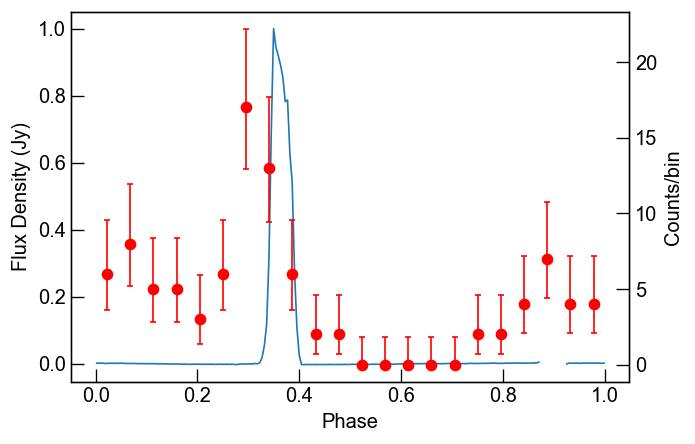

In [8]:
xmax = xcounts.max()

fig = plt.figure(figsize=(6, 4), dpi=120)
ax = fig.add_subplot(1, 1, 1)
ax.plot(rphase, rlc/np.nanmax(rlc), label="meerkat radio")
ax.set_ylabel("Flux Density (Jy)")
ax.set_xlabel("Phase")

ax = ax.twinx()
ax.errorbar(
    xbins, xcounts, yerr=((xcounts - xcount_lolims), (xcount_hilims - xcounts)),
    marker="o", color="red", capsize=2, ls="", label="chandra xray"
)
ax.set_ylabel("Counts/bin")

plt.show()

**Method 1** cross-correlation

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
from scipy.interpolate import interp1d

In [10]:
# interpolate the data...
### add a negative point to make interp smooth
xbins_ = np.concatenate([np.array([xbins[-1]-1]), xbins])
xcounts_ = np.concatenate([np.array([xcounts[-1]]), xcounts])

x_interp_func = interp1d(xbins_, xcounts_, kind="linear", fill_value="extrapolate")
xcounts_interp = x_interp_func(rphase)

rlc_ = rlc.copy()
rlc_[np.isnan(rlc)] = 0.

In [11]:
corr = correlate(xcounts_interp, rlc_, mode="full")

lags = np.linspace(-rphase.max(), rphase.max(), len(corr))

lagmax = lags[np.argmax(corr)]

print("phase lag from auto-correlation yields: ", lagmax)
print("with following error interval", 
      lags[corr > np.max(corr) / 2].min() - lagmax, 
      lags[corr > np.max(corr) / 2].max() - lagmax,
)

phase lag from auto-correlation yields:  -0.05492019605378906
with following error interval -0.05034351304930662 0.06407356206275394


**Method 2** Gaussian fit

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Simulated light curves with Gaussian pulses
def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

poptx, pcovx = curve_fit(gaussian, xbins, xcounts, p0=[16, 0.3, 0.01])
poptr, pcovr = curve_fit(gaussian, rphase, rlc_, p0=[1.2, 0.35, 0.01])

poptx_err = np.sqrt(np.diag(pcovx))
poptr_err = np.sqrt(np.diag(pcovr))

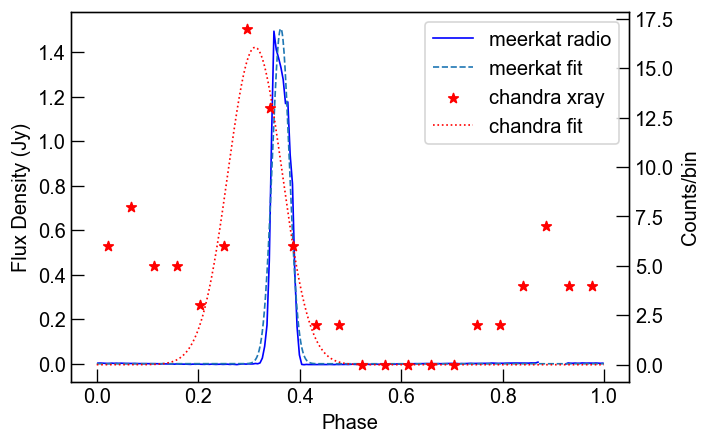

In [13]:
bb = np.linspace(0, 1, 1000)

fig = plt.figure(figsize=(6, 4), dpi=120)
ax = fig.add_subplot(1, 1, 1)

ax.plot(rphase, rlc, color="blue", label="meerkat radio")
xxr = gaussian(bb, *poptr)
ax.plot(bb, xxr, color="C0", ls="--", label="meerkat fit")
ax.set_ylabel("Flux Density (Jy)")
ax.set_xlabel("Phase")

ax = ax.twinx()
ax.plot([], [], color="blue", label="meerkat radio")
ax.plot([], [], color="C0", ls="--", label="meerkat fit")
ax.scatter(xbins, xcounts, color="r", marker="*", label="chandra xray")
xxf = gaussian(bb, *poptx)
ax.plot(bb, xxf, color="r", ls=":", label="chandra fit")
ax.set_ylabel("Counts/bin")

ax.legend()

In [14]:
xmean = poptx[1]; xerr = poptx_err[1]
rmean = poptr[1]; rerr = poptr_err[1]

print("radio mean: ", rmean, "+/-", rerr)
print("xray mean: ", xmean, "+/-", xerr)

print("lag measure (from mean only):", xmean - rmean, "+/-", np.sqrt(xerr**2 + rerr**2))

print("xray guassian sigma: ", poptx[2], )
print("radio guassian sigma: ", poptr[2], )

radio mean:  0.3627989998668869 +/- 0.0003014187373190685
xray mean:  0.3121145840466074 +/- 0.01217873359751011
lag measure (from mean only): -0.050684415820279494 +/- 0.012182463022489686
xray guassian sigma:  0.05337347872975201
radio guassian sigma:  0.016817528381007158
